In [1]:
#sgillen: implementation of trajectory optimization using the five link walker

# jupyter magic 
#==============================================================================

#%load_ext line_profiler

#%lprun -f __main__ __main__()

# imports
#==============================================================================

import math
import numpy as np
import matplotlib.pyplot as plt

from pydrake.all import (BasicVector, DiagramBuilder, FloatingBaseType,
                         RigidBodyPlant, RigidBodyTree, Simulator,SignalLogger, 
                         Isometry3, DirectCollocation, PiecewisePolynomial, VectorSystem)
from pydrake.solvers.mathematicalprogram import Solve

from pydrake.attic.multibody.shapes import VisualElement, Box
from pydrake.attic.multibody.collision import CollisionElement

#from pydrake.all import 
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

from IPython.display import HTML
import matplotlib.pyplot as plt

#this one is home grown, make sure it's in the same directory as this notebook
from seagul.drake import x_expr,y_expr,x_float,y_float,x_taylor,y_taylor
from seagul.resources import getResourcePath 
from numpy import pi

#set up the walker and the ground
#==============================================================================

#load the walker 
tree = RigidBodyTree(FindResource(getResourcePath() + "/five_link.urdf"), FloatingBaseType.kFixed)

box_depth = 100
X = Isometry3(rotation=np.identity(3), translation=[0, 0, -5.])
                
color = np.array([0.9297, 0.7930, 0.6758, 1])
tree.world().AddVisualElement(VisualElement(Box([100., 1., 10.]), X, color))
tree.addCollisionElement(CollisionElement(Box([100., 1., 10.]), X), tree.world(), "the_ground")

tree.compile()

plant = RigidBodyPlant(tree)
context = plant.CreateDefaultContext()

# set up the mathematical program , in this case direct collocation
#==============================================================================

num_time_samples = 21
dircol = DirectCollocation(plant, context, num_time_samples = num_time_samples,
                           minimum_timestep=0.05, maximum_timestep=0.05)

#add constraints
#------------------------------------------------------------------------------
#dircol.AddEqualTimeIntervalsConstraints()

dircol.AddLinearConstraint(dircol.initial_state()[0] - pi == -(dircol.final_state()[0] - pi))
dircol.AddLinearConstraint(dircol.initial_state()[1] ==  -dircol.final_state()[4])
dircol.AddLinearConstraint((dircol.initial_state()[0] + dircol.initial_state()[1] + dircol.initial_state()[2]) ==  (dircol.final_state()[0] + dircol.final_state()[1] + dircol.final_state()[2]))
dircol.AddLinearConstraint(2*pi - dircol.initial_state()[3] == dircol.final_state()[3])
dircol.AddLinearConstraint(dircol.initial_state()[4] == -dircol.final_state()[1])


# TODO Figure out the impact 
dircol.AddLinearConstraint(dircol.initial_state()[5]  == -(dircol.final_state()[5]))
dircol.AddLinearConstraint(dircol.initial_state()[6] ==  - dircol.final_state()[6])
dircol.AddLinearConstraint(dircol.initial_state()[7] + dircol.initial_state()[6] + dircol.initial_state()[5] == dircol.final_state()[7] + dircol.initial_state()[6] + dircol.initial_state()[5])
dircol.AddLinearConstraint(dircol.initial_state()[8] == - dircol.final_state()[8])
dircol.AddLinearConstraint(dircol.initial_state()[9] == -dircol.final_state()[9])

#there is probably a way to have rigid body tree calculate these quantities, but when I tried it did not work at all and this was pretty fast...
x5_in = x_expr(dircol.initial_state())
x5_fn = x_expr(dircol.final_state())

y5_in = y_expr(dircol.initial_state())
y5_fn = y_expr(dircol.final_state())


dircol.AddConstraint(x5_in <= -1)
dircol.AddConstraint(x5_fn >= 1)

dircol.AddConstraint(y5_fn == 0)
dircol.AddConstraint(y5_in == 0)

for i in range(0,num_time_samples):
    dircol.AddConstraint(y_expr(dircol.state(i)) >= 0)

#Add costs
#------------------------------------------------------------------------------

R = 10  # Cost on input "effort".
u = dircol.input()

dircol.AddRunningCost(R*u[0]**2)
dircol.AddRunningCost(R*u[1]**2)
dircol.AddRunningCost(R*u[2]**2)
dircol.AddRunningCost(R*u[3]**2)

for i in range(0,num_time_samples):
    dircol.AddCost(40*(y_taylor(dircol.state(i), 4) - .2))
    
dircol.AddFinalCost(dircol.time())

#Add initial trajectory for the solver
#------------------------------------------------------------------------------

initial_state = (pi - pi/8,    0 , -3*pi/4 - (pi - pi/8) ,  2*pi -( pi/2 + pi/4) ,0, 0,0, 0,0,0)  # initial condition
final_state =   (pi + pi/8,    0 , -3*pi/4 - (pi + pi/8),  3*pi/4 ,0, 0 , 0, 0, 0, 0)  # final condition

initial_x_trajectory = PiecewisePolynomial.FirstOrderHold([0., 4.], np.column_stack((initial_state, final_state)))
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)


#solve the nonlinear program
#==============================================================================

result = Solve(dircol)
if result.is_success():
    print("solver converged")
else:
    print("solver failed to converge")
    
#assert(result == SolutionResult.kSolutionFound)


# define variables later cells will use to acess the trajectory
#==============================================================================

u_trajectory = dircol.ReconstructInputTrajectory(result)
times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
times_index = [i for i in range(times.shape[0])]

u_lookup = np.vectorize(u_trajectory.value)
u_values = np.zeros((times.size,4),float)
for i,t in enumerate(times):
    u_values[i,:] = np.transpose(u_lookup(t))

x_trajectory = dircol.ReconstructStateTrajectory(result)
x_lookup = np.vectorize(x_trajectory.value)
x_values = np.zeros((times.size,10),float)
for i,t in enumerate(times):
    x_values[i,:] = np.transpose(x_lookup(t))

solver converged


False
-0.0008313211389328057


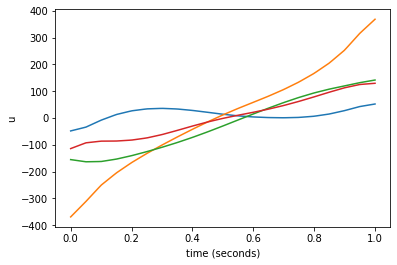

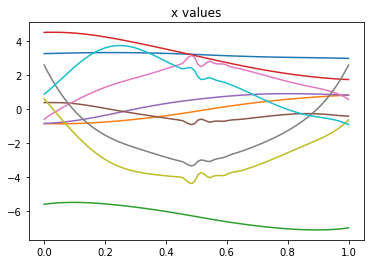

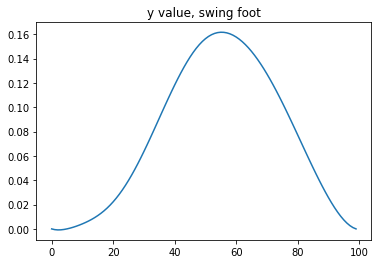

In [2]:
# plot the results
#==============================================================================

    
plt.figure()
plt.plot(times, u_values)
plt.xlabel('time (seconds)')
plt.ylabel('u')

plt.figure()
plt.plot(times, x_values)
plt.title('x values')


y_vals = np.empty([100])
for i,time in enumerate(times):
    #print(x_trajectory.value(time))
    #print(y_float(x_trajectory.value(time)))
    #y_vals.append(y_float(x_trajectory.value(time)))
    y_vals[i] = y_float(x_trajectory.value(time))

plt.figure()
plt.plot(y_vals)
plt.title('y value, swing foot')
print(all(i >= 0 for i in y_vals))
print(min(y_vals))


prbv = PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-1, 2.5])
ani = prbv.animate(x_trajectory, resample=100, repeat=True)
plt.close(prbv.fig)
HTML(ani.to_html5_video())


In [4]:
# Precompute the PFL

q2d = np.zeros((times.shape[0], 5,1))
u_lin =  np.zeros((times.shape[0],4,1))

for i,t in enumerate(times):
    cache = tree.doKinematics(x_lookup(t)[0:5], x_lookup(t)[5:])

    # TODO get that external wrench
    ext_wrench = {}
    for body in tree.get_bodies():
        ext_wrench[body] = np.zeros((6,1))

    Bu = tree.B@u_lookup(t)
    Cq = tree.dynamicsBiasTerm(cache, ext_wrench).reshape(-1,1)
    M = tree.massMatrix(cache)

    q2d[i] = np.linalg.solve(M, Bu - Cq)
    
    M11 = M[0,0].reshape(1,1)
    M12 = M[0,1:].reshape(1,-1)
    M21 = M[1:,0].reshape(-1,1)
    M22 = M[1:,1:]
    
    #u = (M22 - M21@(1/M11)@M12)@q2d[i,1:] - Cq[1:] + M21@(1/M11)*Cq[0]
    u_lin[i] = M21@(1/M11)@(Cq[0] - M12@q2d[i,1:]) + M22@q2d[i,1:] + Cq[1:]

In [ ]:
## Simulate the walker with some sort of tracking controller about the trajectory generated above

# define some controllers
#==============================================================================
  
class tracking_controller(VectorSystem):
    def __init__(self, u_traj, x_traj, kp = 7000, kd = 700):
        VectorSystem.__init__(self,14,4)
        self.x_traj = x_traj
        self.u_traj = u_traj
        self.kp = kp
        self.kd = kd
        
    def DoCalcVectorOutput(self, context, state, _ , output):
        state_des = self.x_traj(context.get_time()).squeeze()
        
        pos_cur = state[1:5]
        vel_cur = state[6:]
        
        pos_des = state_des[1:5]
        vel_des = state_des[6:]
        
        pos_err = pos_des - pos_cur
        vel_err = vel_des - vel_cur
        
        nom_u = self.u_traj(context.get_time()).squeeze()
        output[:] = nom_u + (pos_err*self.kp + vel_err*self.kd)
                         
        #output[:] = u

        
class pfl_controller(VectorSystem):
    def __init__(self, times, u_lin,x_traj, kp = 1000, kd = 100):
        VectorSystem.__init__(self,10,4)
        self.times = np.copy(times)
        self.times_index = [i for i in range(times.shape[0])]
        self.u_lin = np.copy(u_lin)
        
        self.x_traj = x_traj
        self.kp = kp
        self.kd = kd
    
    def DoCalcVectorOutput(self, context, state, _, output):
        
        state_des = self.x_traj(context.get_time()).squeeze()

        pos_cur = state[1:5]
        vel_cur = state[6:]
        
        pos_des = state_des[1:5]
        vel_des = state_des[6:]
        
        pos_err = pos_des - pos_cur
        vel_err = vel_des - vel_cur
    
        t = context.get_time()
        interp_index = np.interp([t], self.times, self.times_index)

        interp_lin_u = np.zeros_like(output)
        for i,u in enumerate(interp_lin_u):
            u = np.interp(interp_index, self.times_index, self.u_lin.squeeze()[:,i])

        output[:] = interp_lin_u + (pos_err*self.kp + vel_err*self.kd)
       
    
# set up the walker and the ground
#==============================================================================

#load the walker 
tree = RigidBodyTree(FindResource(getResourcePath() + "/five_link.urdf"), FloatingBaseType.kFixed)

box_depth = 100
X = Isometry3(rotation=np.identity(3), translation=[0, 0, -5.])
                
color = np.array([0.9297, 0.7930, 0.6758, 1])
tree.world().AddVisualElement(VisualElement(Box([100., 1., 10.]), X, color))
tree.addCollisionElement(CollisionElement(Box([100., 1., 10.]), X), tree.world(), "the_ground")

tree.compile()

builder = DiagramBuilder()
robot = builder.AddSystem(RigidBodyPlant(tree))
#controller = builder.AddSystem(passive_controller(u_lookup, x_lookup))
controller  = builder.AddSystem(pfl_controller(times, u_lin, x_lookup, kp=7000, kd=700))

state_logger = builder.AddSystem(SignalLogger(robot.get_output_port(0).size()))
state_logger.DeclarePeriodicPublish(1.0 / 30.0, 0.0)

u_logger = builder.AddSystem(SignalLogger(controller.get_output_port(0).size()))
u_logger.DeclarePeriodicPublish(1.0 / 30.0, 0.0)


builder.Connect(robot.get_output_port(0), state_logger.get_input_port(0))
builder.Connect(controller.get_output_port(0), u_logger.get_input_port(0))
builder.Connect(robot.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), robot.get_input_port(0))

diagram = builder.Build()

simulator = Simulator(diagram)
simulator.set_publish_every_time_step(False)

context = simulator.get_mutable_context()
state = context.get_mutable_continuous_state_vector()
state.SetFromVector(x_lookup(0))  # initial condition

simulator.StepTo(5)

plt.figure()
plt.plot(times, u_values)
plt.xlabel('time (seconds)')
plt.ylabel('u')

prbv = PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-5, 2.5])
ani = prbv.animate(state_logger, repeat=True)
plt.close(prbv.fig)
HTML(ani.to_html5_video())

In [ ]:
## Inverse Dynamics

cache = tree.doKinematics(x_lookup(0)[0:5], x_lookup(0)[5:])

ext_wrench = {}
for body in tree.get_bodies():
    ext_wrench[body] = np.zeros((6,1))
    
q2d = np.array([0,0,0,0,0], dtype=np.double)

tree.inverseDynamics(cache, ext_wrench, q2d)
tree.massMatrix(cache)
tree.dynamicsBiasTerm(cache, ext_wrench)


In [24]:
## Simulate the walker with some sort of tracking controller about the trajectory generated above

import pydrake
from seagul.drake import y_float_prism

# define some controllers
#==============================================================================
  
class tracking_controller(VectorSystem):
    def __init__(self, u_traj, x_traj, kp = 7000, kd = 700):
        VectorSystem.__init__(self,14,4)
        self.x_traj = x_traj
        self.u_traj = u_traj
        self.kp = kp
        self.kd = kd
        
    def DoCalcVectorOutput(self, context, state, _ , output):
        state_des = self.x_traj(context.get_time()).squeeze()
        
        pos_cur = state[3:7]
        vel_cur = state[10:]
        
        pos_des = state_des[1:5]
        vel_des = state_des[6:]
        
        pos_err = pos_des - pos_cur
        vel_err = vel_des - vel_cur
        
        nom_u = self.u_traj(context.get_time()).squeeze()
        output[:] = (nom_u + (pos_err*self.kp + vel_err*self.kd))[::-1]
                         
        #output[:] = u

        
class pfl_controller(VectorSystem):
    def __init__(self, times, u_lin,x_traj, kp = 1000, kd = 100):
        VectorSystem.__init__(self,14,4)
        self.times = np.copy(times)
        self.times_index = [i for i in range(times.shape[0])]
        self.u_lin = np.copy(u_lin)
        
        self.x_traj = x_traj
        self.kp = kp
        self.kd = kd
    
    def DoCalcVectorOutput(self, context, state, _, output):
        
        state_des = self.x_traj(context.get_time()).squeeze()

        pos_cur = state[3:7]
        vel_cur = state[10:]
        
        pos_des = state_des[1:5]
        vel_des = state_des[6:]
        
        pos_err = pos_des - pos_cur
        vel_err = vel_des - vel_cur
    
        t = context.get_time()
        interp_index = np.interp([t], self.times, self.times_index)

        interp_lin_u = np.zeros_like(output)
        for i,u in enumerate(interp_lin_u):
            u = np.interp(interp_index, self.times_index, self.u_lin.squeeze()[:,i])

        output[:] = np.zeros(4) + (pos_err*self.kp + vel_err*self.kd)
        
        
class passive_controller(VectorSystem):
    """
    Drake controller which just outputs zero as the control output
    """
    def __init__(self):
        VectorSystem.__init__(self,14,4)

        
    def DoCalcVectorOutput(self, context, state, _ , output):
        output[:] = np.zeros((4))
                         
        #output[:] = u

    
# set up the walker and the ground
#==============================================================================

#load the walker 
tree = RigidBodyTree(FindResource(getResourcePath() + "/five_link_prism.urdf"), FloatingBaseType.kFixed)

box_depth = 100
X = Isometry3(rotation=np.identity(3), translation=[0, 0, -5.])
                
color = np.array([0.9297, 0.7930, 0.6758, 1])
tree.world().AddVisualElement(VisualElement(Box([100., 10., 10.]), X, color))
tree.addCollisionElement(CollisionElement(Box([100., 10., 10.]), X), tree.world(), "the_ground")

tree.compile()

builder = DiagramBuilder()
robot = builder.AddSystem(RigidBodyPlant(tree))

# set the friction properties
material = pydrake.attic.multibody.rigid_body_plant.CompliantMaterial(1e8,10,.7,.6) #TODO 
robot.set_default_compliant_material(material)

controller = builder.AddSystem(tracking_controller(u_lookup_r, x_lookup_r))
#controller  = builder.AddSystem(pfl_controller(times, u_lin, x_lookup,  kp=7000, kd=700))
#controller  = builder.AddSystem(passive_controller())


state_logger = builder.AddSystem(SignalLogger(robot.get_output_port(0).size()))
state_logger.DeclarePeriodicPublish(1.0 / 30.0, 0.0)

u_logger = builder.AddSystem(SignalLogger(controller.get_output_port(0).size()))
u_logger.DeclarePeriodicPublish(1.0 / 30.0, 0.0)


builder.Connect(robot.get_output_port(0), state_logger.get_input_port(0))
builder.Connect(controller.get_output_port(0), u_logger.get_input_port(0))
builder.Connect(robot.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), robot.get_input_port(0))

diagram = builder.Build()

simulator = Simulator(diagram)
simulator.set_publish_every_time_step(False)
integrator = simulator.get_integrator()
integrator.set_fixed_step_mode(True)
integrator.set_maximum_step_size(.0005)

context = simulator.get_mutable_context()
state = context.get_mutable_continuous_state_vector()

init_xy = np.array([0,0]).reshape(-1,1)
init_dxdy = np.array([0,0]).reshape(-1,1)
init_state = np.concatenate((init_xy, x_lookup_r(0)[0:5], init_dxdy,x_lookup_r(0)[5:]))
state.SetFromVector(init_state)  # initial condition


simulator.StepTo(5)
print("all done")

KeyboardInterrupt: 

False
-0.9789165109467587


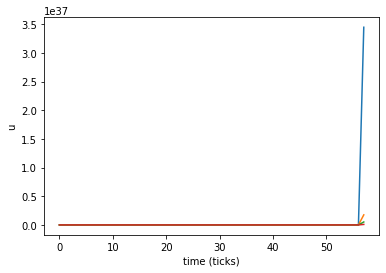

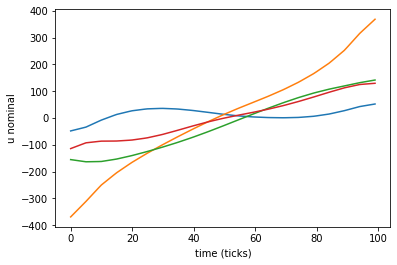

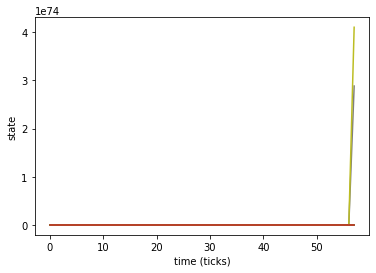

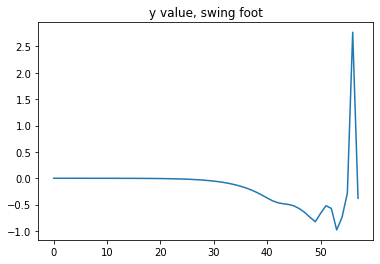

In [23]:
plt.figure()
plt.plot(u_logger.data().transpose(1,0))
plt.xlabel('time (ticks)')
plt.ylabel('u')

plt.figure()
plt.plot(u_values)
plt.xlabel('time (ticks)')
plt.ylabel('u nominal')

plt.figure()
plt.plot(state_logger.data().transpose(1,0))
plt.xlabel('time (ticks)')
plt.ylabel('state')

y_vals = []
for state in state_logger.data().transpose(1,0):
    #print(x_trajectory.value(time))
    #print(y_float(x_trajectory.value(time)))
    #y_vals.append(y_float(x_trajectory.value(time)))
    #print(state.shape)
    #print((y_float(state)))
    y_vals.append(y_float_prism(state))

plt.figure()
plt.plot(y_vals)
plt.title('y value, swing foot')
print(all(i >= 0 for i in y_vals))
print(min(y_vals))

prbv = PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-5, 2.5])
ani = prbv.animate(state_logger, repeat=True)
plt.close(prbv.fig)
HTML(ani.to_html5_video())


In [12]:
u_lookup_r = lambda t: u_lookup(1-t)
x_lookup_r = lambda t: x_lookup(1-t)